# Modelo de Regresión para la Predicción de Accidentes de Tráfico en Madrid al día mediante Redes Neuronales Recurrentes
## Un Enfoque de Deep Learning para Análisis de Series Temporales

In [462]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

In [463]:
df = pd.read_pickle("accidentes.pkl")

In [464]:
df.head()

accidente_id      fecha_completa      fecha   rango_horario  \
0      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00   
1      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00   
2      2010.135 2010-01-01 00:00:00 2010-01-01 0 days 00:00:00   
3      2010.940 2010-01-01 01:00:00 2010-01-01 0 days 01:00:00   
4      2010.940 2010-01-01 01:00:00 2010-01-01 0 days 01:00:00   

                                        localizacion numero  \
0  calle de cartagena num                        ...    104   
1  calle de cartagena num                        ...    104   
2  calle de cartagena num                        ...    104   
3  autovia  m-30 calzada 2 km.                   ...  10200   
4  autovia  m-30 calzada 2 km.                   ...  10200   

             distrito coordenada_x coordenada_y     condicion  \
0           chamartin          NaN          NaN  desfavorable   
1           chamartin          NaN          NaN  desfavorable   
2           chamartin          NaN          NaN  desfavorable   
3  puente de vallecas          NaN          NaN     favorable   
4  puente de vallecas          NaN          NaN     favorable   

                          lesividad persona_implicada  positiva_alcohol  \
0              ingreso inferior 24h         conductor               NaN   
1              ingreso inferior 24h         conductor               NaN   
2  asistencia sanitaria sin ingreso          pasajero               NaN   
3  asistencia sanitaria sin ingreso          pasajero               NaN   
4  asistencia sanitaria sin ingreso          pasajero               NaN   

   positiva_droga  rango_edad    sexo     tipo_accidente tipo_vehiculo  \
0             NaN         5.0  hombre     colision doble       turismo   
1             NaN        12.0  hombre     colision doble       turismo   
2             NaN        10.0   mujer     colision doble       turismo   
3             NaN         7.0   mujer  colision multiple           NaN   
4             NaN         8.0   mujer  colision multiple           NaN   

   victimas  
0       1.0  
1       1.0  
2       1.0  
3       7.0  
4       7.0

In [465]:
df.dropna(subset=['distrito'], inplace=True)

In [466]:
# Códigos reales de distrito de la Comunidad de Madrid: 

codigo_distrito = {'centro': 1, 
                   'arganzuela': 2, 
                   'retiro': 3, 
                   'salamanca': 4, 
                   'chamartin': 5, 
                   'tetuan': 6, 
                   'chamberi': 7, 
                   'fuencarral-el pardo': 8, 
                   'moncloa-aravaca': 9, 
                   'latina': 10, 
                   'carabanchel': 11, 
                   'usera': 12, 
                   'puente de vallecas': 13, 
                   'moratalaz': 14, 
                   'ciudad lineal': 15, 
                   'hortaleza': 16, 
                   'villaverde': 17, 
                   'villa de vallecas': 18, 
                   'vicalvaro': 19, 
                   'san blas-canillejas': 20, 
                   'barajas': 21}

In [467]:
df['distrito'] = df['distrito'].map(codigo_distrito)

In [468]:
# Agrupacion de datos por fecha y distrito, contando la cantidad de accidentes unicos
target = df.groupby(["fecha", 'distrito'])['accidente_id'].nunique().reset_index()

# Renombrando la columna 'accidente_id' por 'numero_accidentes'
target.rename(columns={'accidente_id': 'numero_accidentes'}, inplace=True)

target.head()

fecha  distrito  numero_accidentes
0 2010-01-01         3                  1
1 2010-01-01         4                  2
2 2010-01-01         5                  1
3 2010-01-01         6                  2
4 2010-01-01         7                  1

In [469]:
target.shape

(78499, 3)

In [470]:
# Agregar valores faltantes
fechas_unicas = pd.date_range(start = target['fecha'].min(), end=target['fecha'].max(), freq = 'D')
distritos_unicos = target['distrito'].unique()

# Creamos un MultiIndex con todas las combinaciones posibles de fechas y distritos
nuevos_indices = pd.MultiIndex.from_product([fechas_unicas, distritos_unicos], names = ['fecha', 'distrito'])

# Creamos un DataFrame con los nuevos índices y lo fusionamos con el DataFrame original
df_completo = pd.DataFrame(index = nuevos_indices).merge(target, left_index = True, right_on = ['fecha', 'distrito'], how = 'left')

In [471]:
# Agregar las variables de año, mes y dia 
df_completo['año'] = df_completo['fecha'].dt.year
df_completo['mes'] = df_completo['fecha'].dt.month
df_completo['dia'] = df_completo['fecha'].dt.day

In [472]:
# Reemplazamos los valores NaN con 0 en la columna 'numero_accidentes'
df_completo['numero_accidentes'].fillna(0, inplace=True)

In [473]:
fig= px.box(data_frame = target,
       x          = 'numero_accidentes',
       title= 'Número de accidentes')
fig.update_layout(title_x=0.5)

In [474]:
df_completo.shape

(108024, 6)

In [475]:
df_completo.head()

fecha  distrito  numero_accidentes   año  mes  dia
0 2010-01-01         3                1.0  2010    1    1
1 2010-01-01         4                2.0  2010    1    1
2 2010-01-01         5                1.0  2010    1    1
3 2010-01-01         6                2.0  2010    1    1
4 2010-01-01         7                1.0  2010    1    1

In [476]:
# Pasamos el número de accidentes a entero
df_completo['numero_accidentes'] = df_completo['numero_accidentes'].astype(int)

In [477]:
# Contar los ceros para 'numero_accidentes' en cada distrito
ceros_por_distrito = df_completo[df_completo['numero_accidentes'] == 0].groupby('distrito').size().sort_values(ascending = False).reset_index()
ceros_por_distrito = ceros_por_distrito.rename(columns = {0:'dias_sin_accidentes'})
ceros_por_distrito

distrito  dias_sin_accidentes
0         19                 3142
1         21                 2963
2         18                 2316
3         14                 2307
4         17                 2094
5         12                 1712
6         16                 1611
7         20                 1223
8          2                 1193
9         10                 1131
10         3                 1131
11         6                 1095
12         9                 1046
13         7                 1024
14         8                  969
15        15                  873
16        13                  832
17        11                  826
18         5                  745
19         4                  646
20         1                  646

In [478]:
distritos = ['centro', 'arganzuela', 'retiro', 'salamanca', 'chamartin', 'tetuan', 
             'chamberi', 'fuencarral-el pardo', 'moncloa-aravaca', 'latina', 'carabanchel', 
             'usera', 'puente de vallecas', 'moratalaz', 'ciudad lineal', 'hortaleza', 'villaverde',
              'villa de vallecas', 'vicalvaro', 'san blas-canillejas', 'barajas']

valores_distritos = list(range(1, len(distritos) + 1))

fig = px.bar(x=ceros_por_distrito['distrito'], y = ceros_por_distrito['dias_sin_accidentes'],
             labels = {'x': 'Distrito', 'y': 'Días'},
             title = 'Días sin accidentes por distrito',
             color_discrete_sequence = ['limegreen'],
                          opacity = 0.5)


fig.update_layout(xaxis = {'title': 'Distritos', 'tickmode': 'array', 
                         'tickvals': valores_distritos, 
                         'ticktext': distritos},
                  title_x = 0.5)

fig.show()

In [479]:
# Pasar la fecha a los índices

df_completo.set_index(df_completo.columns[0], inplace = True)
df_completo.head()

distrito  numero_accidentes   año  mes  dia
fecha                                                  
2010-01-01         3                  1  2010    1    1
2010-01-01         4                  2  2010    1    1
2010-01-01         5                  1  2010    1    1
2010-01-01         6                  2  2010    1    1
2010-01-01         7                  1  2010    1    1

In [480]:
# Guardar la target 
df_completo.to_pickle("accidentes_series_temporales.pkl")
df = pd.read_pickle("accidentes_series_temporales.pkl")

Los accidentes están entre 1 y 16

In [481]:
df.describe()

distrito  numero_accidentes            año            mes  \
count  108024.000000      108024.000000  108024.000000  108024.000000   
mean       11.000000           1.697743    2016.544907       6.490086   
std         6.055329           1.684704       4.060306       3.464665   
min         1.000000           0.000000    2010.000000       1.000000   
25%         6.000000           0.000000    2013.000000       3.000000   
50%        11.000000           1.000000    2017.000000       7.000000   
75%        16.000000           3.000000    2020.000000      10.000000   
max        21.000000          16.000000    2024.000000      12.000000   

                 dia  
count  108024.000000  
mean       15.729977  
std         8.800489  
min         1.000000  
25%         8.000000  
50%        16.000000  
75%        23.000000  
max        31.000000

In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108024 entries, 2010-01-01 to 2024-01-31
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   distrito           108024 non-null  int64
 1   numero_accidentes  108024 non-null  int32
 2   año                108024 non-null  int32
 3   mes                108024 non-null  int32
 4   dia                108024 non-null  int32
dtypes: int32(4), int64(1)
memory usage: 3.3 MB


In [483]:
df.shape

(108024, 5)

In [484]:
# Accidentes mensuales por distrito
accidentes_mensuales_distrito = df.groupby([pd.Grouper(freq = 'm'), 'distrito']).sum()
accidentes_mensuales_distrito

numero_accidentes    año  mes  dia
fecha      distrito                                    
2010-01-31 1                        43  62310   31  496
           2                        29  62310   31  496
           3                        33  62310   31  496
           4                        47  62310   31  496
           5                        42  62310   31  496
...                                ...    ...  ...  ...
2024-01-31 17                       60  62744   31  496
           18                       47  62744   31  496
           19                       29  62744   31  496
           20                       82  62744   31  496
           21                       38  62744   31  496

[3549 rows x 4 columns]

In [485]:
# Accidentes anuales por distrito

accidentes_anuales_distrito = df.groupby([pd.Grouper(freq = 'y'), 'distrito']).sum()
accidentes_anuales_distrito

numero_accidentes     año   mes   dia
fecha      distrito                                       
2010-12-31 1                       668  733650  2382  5738
           2                       477  733650  2382  5738
           3                       427  733650  2382  5738
           4                       670  733650  2382  5738
           5                       682  733650  2382  5738
...                                ...     ...   ...   ...
2024-12-31 17                       60   62744    31   496
           18                       47   62744    31   496
           19                       29   62744    31   496
           20                       82   62744    31   496
           21                       38   62744    31   496

[315 rows x 4 columns]

In [486]:
accidentes_anuales_distrito

numero_accidentes     año   mes   dia
fecha      distrito                                       
2010-12-31 1                       668  733650  2382  5738
           2                       477  733650  2382  5738
           3                       427  733650  2382  5738
           4                       670  733650  2382  5738
           5                       682  733650  2382  5738
...                                ...     ...   ...   ...
2024-12-31 17                       60   62744    31   496
           18                       47   62744    31   496
           19                       29   62744    31   496
           20                       82   62744    31   496
           21                       38   62744    31   496

[315 rows x 4 columns]

In [487]:
fig = px.line(df, x = df.index, y = "numero_accidentes", color = 'distrito', title = 'Evolución del número de accidentes por distrito')
fig.update_layout(title_x=0.5)
fig.show()

# EMPIEZA EL MODELO

In [488]:
df_distrito = df.reset_index(drop = False).groupby(["fecha"]).agg({"numero_accidentes" : "sum", "año": "first"})

In [489]:
df_distrito.head()

numero_accidentes   año
fecha                              
2010-01-01                 12  2010
2010-01-02                 15  2010
2010-01-03                 16  2010
2010-01-04                 27  2010
2010-01-05                 21  2010

In [490]:
min_accidentes = df_distrito["numero_accidentes"].min()
max_accidentes = df_distrito["numero_accidentes"].max()

print("Valor mínimo de accidentes por día:", min_accidentes)
print("Valor máximo de accidentes por día:", max_accidentes)

Valor mínimo de accidentes por día: 1
Valor máximo de accidentes por día: 120


In [491]:
# Día que hubo más accidentes: Hubo una nevada

#"Una mujer de 62 años ha resultado herida grave y otras 35 personas 
# leves en las colisiones entre 50 vehículos a lo largo de dos kilómetros"

# https://elpais.com/ccaa/2019/04/05/madrid/1554473412_548650.html

df_distrito[df_distrito["numero_accidentes"] == max_accidentes]

numero_accidentes   año
fecha                              
2019-04-05                120  2019

In [492]:
fig= px.box(data_frame = df_distrito["numero_accidentes"],
       x          = 'numero_accidentes',
       title= 'Número de accidentes por día')
fig.update_layout(title_x=0.5)

In [493]:
df_distrito.shape

(5144, 2)

In [494]:
# A partir de 80 tenemos outliers, aproximadamente el 1.63% de los datos
# 84 días hubo más de 80 accidentes
num_accidentes_mayor_80 = (df_distrito["numero_accidentes"] > 80).sum()
num_accidentes_mayor_80

84

In [495]:
# Se crean diccionarios para mapear los años a etiquetas especificas.
map_año_1 = {i : "Datos Viejos" for i in range(2010, 2019)}
map_año_2 = {2019 : "Datos Raros"}
map_año_3 = {2020 : "COVID"}
map_año_4 = {i : "Datos Nuevos" for i in range(2021, 2025)}

map_año_1.update(map_año_2)
map_año_1.update(map_año_3)
map_año_1.update(map_año_4)

df_distrito["datos"] = df_distrito["año"].apply(lambda x : map_año_1[x])

In [496]:
# Train es menor de 2021 (del gráfico de abajo: azul, rojo y verde)
# Test es menor de 2023 (del gráfico de abajo: morado)

df_distrito["Train/Test"] = df_distrito["año"].apply(lambda x : "Train" if 2021 <= x < 2023 else "Test")

In [497]:
df_distrito

numero_accidentes   año         datos Train/Test
fecha                                                       
2010-01-01                 12  2010  Datos Viejos       Test
2010-01-02                 15  2010  Datos Viejos       Test
2010-01-03                 16  2010  Datos Viejos       Test
2010-01-04                 27  2010  Datos Viejos       Test
2010-01-05                 21  2010  Datos Viejos       Test
...                       ...   ...           ...        ...
2024-01-27                 44  2024  Datos Nuevos       Test
2024-01-28                 39  2024  Datos Nuevos       Test
2024-01-29                 51  2024  Datos Nuevos       Test
2024-01-30                 63  2024  Datos Nuevos       Test
2024-01-31                 50  2024  Datos Nuevos       Test

[5144 rows x 4 columns]

In [498]:
datos = df_distrito.drop(["año"], axis = 1)

datos.shape

(5144, 3)

In [499]:
fig = px.line(df_distrito, x = df_distrito.index, y = 'numero_accidentes', color = "datos", title = 'Número de Accidentes a lo largo del tiempo en el Distrito Centro')
fig.update_layout(title_x = 0.5)

fig.show()

In [500]:
# definir train y test
train = df_distrito[(df_distrito["Train/Test"] == "Train")]["numero_accidentes"].values

test = df_distrito[(df_distrito["Train/Test"] == "Test")]["numero_accidentes"].values

In [501]:
def segmentos_T(datos, T):

    # T = 40 # Segmentos
    X = list()
    y = list()

    for t in range(len(datos) - T):
        
        # Toma valores de X de t en t con stride de 1
        x = datos[t : t + T]
        X.append(x)
        
        # Toma los valores de t en t
        y_ = datos[t + T]
        y.append(y_)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)
    N = len(X)

    return X, y, N

In [502]:
T = 7

X_train, y_train, N_train = segmentos_T(datos = train, T = T)
X_test, y_test, N_test = segmentos_T(datos = test, T = T)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((723, 7, 1), (723,), (4407, 7, 1), (4407,))

In [503]:
modelo = Sequential()

modelo.add(Input(shape = (T, 1)))

modelo.add(GRU(units=32, input_shape=X_train.shape[1:], return_sequences=False))
modelo.add(LeakyReLU(alpha=0.1))  

modelo.add(Dense(units = 60, activation = "relu")) 
modelo.add(Dense(units = 30, activation = "relu")) 
modelo.add(Dense(units = 15, activation = "relu")) 

# Capa de salida, como es de regresión, es 1
modelo.add(Dense(units = 1))

modelo.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'mse', metrics=['mae'])

modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 32)                3360      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 60)                1980      
                                                                 
 dense_33 (Dense)            (None, 30)                1830      
                                                                 
 dense_34 (Dense)            (None, 15)                465       
                                                                 
 dense_35 (Dense)            (None, 1)                 16        
                                                                 
Total params: 7651 (29.89 KB)
Trainable params: 7651 (

In [504]:
# Define los callbacks (si empieza a memorizar dile que pare las épocas, por eso da igual cuantas poner)

callback_val_loss = EarlyStopping(monitor = "val_loss", patience = 50)

In [505]:
# Entrena el modelo

history = modelo.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 1000,
                    callbacks = [callback_val_loss])

Epoch 1/1000


23/23 [==============================] - 2s 18ms/step - loss: 2881.2847 - mae: 51.5591 - val_loss: 1299.5098 - val_mae: 32.0269
Epoch 2/1000
23/23 [==============================] - 0s 8ms/step - loss: 2854.3657 - mae: 51.2978 - val_loss: 1282.2039 - val_mae: 31.7533
Epoch 3/1000
23/23 [==============================] - 0s 7ms/step - loss: 2826.9163 - mae: 51.0281 - val_loss: 1264.2075 - val_mae: 31.4660
Epoch 4/1000
23/23 [==============================] - 0s 7ms/step - loss: 2797.8757 - mae: 50.7431 - val_loss: 1244.9332 - val_mae: 31.1558
Epoch 5/1000
23/23 [==============================] - 0s 7ms/step - loss: 2765.9021 - mae: 50.4261 - val_loss: 1223.4796 - val_mae: 30.8062
Epoch 6/1000
23/23 [==============================] - 0s 7ms/step - loss: 2730.0425 - mae: 50.0716 - val_loss: 1199.4895 - val_mae: 30.4096
Epoch 7/1000
23/23 [==============================] - 0s 7ms/step - loss: 2690.0564 - mae: 49.6675 - val_loss: 1172.7103 - val_mae: 29.9588
Epoch 8/1000
23/23 [============

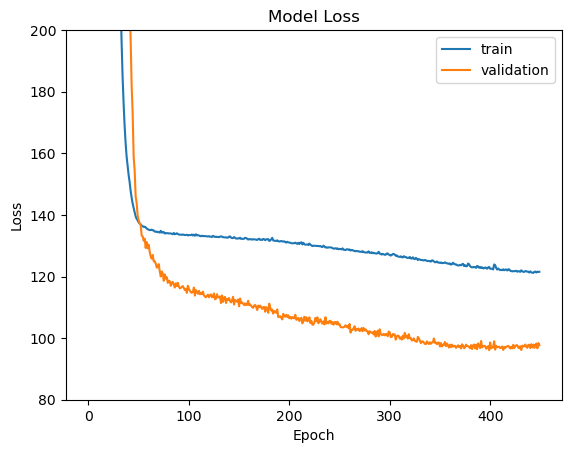

In [506]:
# Visualiza la pérdida durante el entrenamiento

plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(80, 200)
plt.show()

In [507]:
# Definimos el yhat y redondeamos a número entero porque no puede haber 1,4 accidentes es 1 o 2
yhat = np.round(modelo.predict(X_test))
# cantidad de predicciones, 1 porque es un modelo de regresión
yhat.shape

138/138 [==============================] - 0s 839us/step


(4407, 1)

In [508]:
# Media de accidentes de todos los distritos 
df_distrito["numero_accidentes"].mean()

35.65260497667185

In [509]:
# Métricas para evaluar el modelo de regresión

r2 = r2_score(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mean_squared_error(y_test, yhat))
linear_model = [[str(modelo), modelo, r2, mae, mse, rmse]]
df_metricas_regresion = pd.DataFrame(data = linear_model, columns = ["nombre", "modelo", "r2", "mae", "mse", "rmse"])
df_metricas_regresion

# Falla por 9 accidentes

nombre  \
0  <keras.src.engine.sequential.Sequential object...   

                                              modelo        r2       mae  \
0  <keras.src.engine.sequential.Sequential object...  0.646276  7.873837   

         mse      rmse  
0  97.701384  9.884401

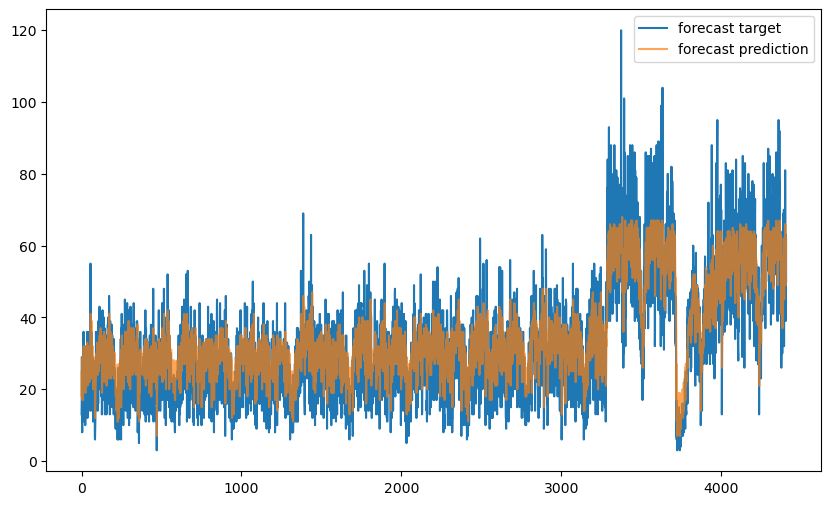

In [510]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test, label="forecast target")  
plt.plot(yhat.flatten(), label="forecast prediction", alpha=0.7)  
plt.legend()
plt.show() 

In [516]:
df = pd.DataFrame({'Datos de prueba': y_test, 'Prediccion': yhat.flatten()})

fig = px.line(df, labels = {'index': 'Range'}, title = 'Comparación de Datos de Prueba y Predicciones')

fig.update_layout(title_x = 0.5)
fig.show()

# CONCLUSION

El modelo utilizado (GRU) ha demostrado un (R^2) de aproximadamente 0.639, lo que indica que el modelo tiene un acierto de 63.9%.
El (MAE) obtenido es de alrededor de 7.981, lo que significa que, en promedio, las predicciones del modelo se desvían en aproximadamente 7.98 unidades de la variable dependiente de sus valores reales.

En resumen, el modelo ha demostrado cierta capacidad para predecir la variable, aunque es importante mencionar que la forma cambiante de recoger los datos (a partir de 2019) también ha afectado al resultado final del modelo. Los datos muestran una gran irregularidad, especialmente en 2019 y 2020. Habiendo dicho esto, los valores de los errores indican que todavía existe margen de mejora. Es importante seguir evaluando y refinando el modelo para aumentar su rendimiento predictivo.